# Experiment Comparison

In this notebook, we will compare the results of our simulator with real data from AWS Lambda.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim


def process_aws(arrival_rate, st_w, st_c, max_time=1e6):
    sim = Sim(arrival_rate=arrival_rate,
                warm_service_rate=1/st_w, 
                cold_service_rate=1/st_c,
                expiration_threshold=600, 
                max_time=max_time)
    sim.generate_trace(debug_print=False, progress=True)
    return sim.get_cold_start_prob()

In [13]:
# load experiments
exp_df = pd.read_csv('exp.csv', index_col=0)

st_w_avg = exp_df['ServiceTimeWarm'].mean()
st_c_avg = exp_df['ServiceTimeCold'].mean()

def get_row_cold_prob(x):
    return process_aws(
        arrival_rate=x['ArrivalRate'],
        st_w=st_w_avg / 1000,
        st_c=st_c_avg / 1000,
    )

sim_cold_probs = exp_df.apply(get_row_cold_prob, axis=1)
sim_cold_probs

100%|██████████| 1000000/1000000 [00:44<00:00, 22292.23it/s]


experiment_0    0.007177
experiment_5    0.003814
experiment_1    0.002658
experiment_6    0.002416
experiment_2    0.002076
experiment_7    0.001784
experiment_3    0.001594
experiment_4    0.001299
dtype: float64

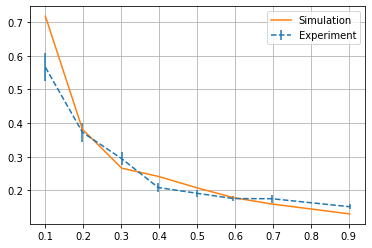

In [15]:
plt.errorbar(exp_df['ArrivalRate'], exp_df['ColdStartProbability']
         * 100, yerr=exp_df['ColdStartProbabilitySE'] * 100, ls='--', label='Experiment')
plt.plot(exp_df['ArrivalRate'], sim_cold_probs * 100, label='Simulation')
plt.legend()
plt.grid(True)